# True Reach Estimator

***

We are looking to build an estimator around instagram users true reach and impressions. This data is accessible through the business api but in Q1 2018 Instagram blocked influencer marketing teams from this endpoint. We are able to collect a sample of this data to see if there working correlations between currently public data and true reach/impressions. 

Data: the CSV we have contains one year worth of data from 5,000 influencer level Instagram users. 

## The goal: 
Given the public data points create an accurate estimate of each posts reach and impressions. The ideal would be as accurate as possible, but a 10% range will work for the business. 

# Group 2 - Followers = 5K-12.5K

After many trials we have settled on a 3 variable regression model that uses comments, likes and followers to predict our final reach estimate. 

In order to fit the model most accurately to a normal situation we had to remove special outliers. Instagram's algorithm produces larger variance in individual results. These results had a detrimental effect on any prediction results. Eliminating outliers of a single large or small variable has a negative effect on our model as our users vary greatly. However, we determined that issues arose when the ratio of certain variables violated normality. As such, we chose to eliminate the upper and lower 10% of the offending ratios to help fit the model.

For this group we have only included users with followers from 5,000 to 12,500 to better match the reactions to posts. 

Process:

- work with users that have  5k-12.5k followers.
- Change the confidence interval to 10% or 90%.

- Import the data
- Split the data into a test and training set
- Set conditions on the training data to eliminate outliers
- Create a regression model on our variables to determine the effectiveness of the data so far 
- Use the regression model to check for accuracy in the prediction across the dataset
- Summarize our findings and suggest next steps if unsucessful

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use('seaborn')
%matplotlib inline

Pull in the CSV file

In [2]:
df = pd.read_csv('trial_1_2.csv')

First, look at the data

In [3]:
df.head()

,Unnamed: 0,followers,published,likes,comments,impressions,reach
0,0,68172,2018-06-18T01:26:44.000+00:00,107,1,2301,1782
1,1,68172,2018-06-17T18:47:24.000+00:00,323,1,9563,8131
2,2,68223,2018-06-19T02:24:03.000+00:00,38,1,290,261
3,3,68223,2018-06-18T16:44:25.000+00:00,656,12,11360,9082
4,4,67812,2018-05-30T03:22:11.000+00:00,2044,26,100970,85215


Drop columns that are unneeded.

In [4]:
df.drop(['Unnamed: 0', 'published', 'impressions'], axis=1, inplace=True)

**First Data Clean**

Anyone with very little reach will skew the data. It's probably a bot. Lets remove all rows where the reach is less than 1.

In [5]:
df = df.loc[(df['reach']>=1)] #& (df2['reach']<200000)
len(df)

727933

### Set bin for follower count
Next we decided to remove rows that have less than 5000 followers. This not only helps eliminate outliers but in the data collection there were many rows with exactly zero followers yet high numbers in reach. This data clearly is not correct or not in the style we are looking for. We want to look at the different category.

In [6]:
df = df.loc[(df['followers']>5000) & (df['followers']<12500)]
len(df)

107938

Setting comments to greater than zero to avoid zero division errors

In [7]:
df = df.loc[(df['comments']>=1)] # & (df2['comments']<=2000)
len(df)

104160

Remove rows with less than 1 like to eliminate outliers.

In [8]:
df = df.loc[(df['likes']>=1)]
len(df)

104160

Remove wierd situations where there are more comments or likes than reach.

In [9]:
df = df.loc[(df.likes<df.reach)]
df = df.loc[(df.comments<df.reach)]
len(df)

101708

## Split the data sets into two - a test and a training data set: 

In [10]:
from sklearn.model_selection import train_test_split
df2, test = train_test_split(df, test_size=0.2)

In [11]:
len(df2)

81366

---

# Eliminate the data with *RATIOS* outside of the norm. 

## Step 1 - Add ratio colums onto the data frame

In [12]:
df2['reach_/_followers'] = df2['reach']/df2['followers']

In [13]:
df2['reach_/_likes'] = df2['reach']/df2['likes']

In [14]:
df2['reach_/_comments'] = df2['reach']/df2['comments']

#### Look at the distribution of those ratio without manipulation

(-0.0004, 1000)

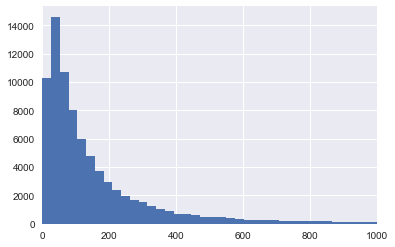

In [15]:
plt.hist(df2['reach_/_comments'], bins=1000)
plt.xlim(-.0004,1000)

(-0.03, 3)

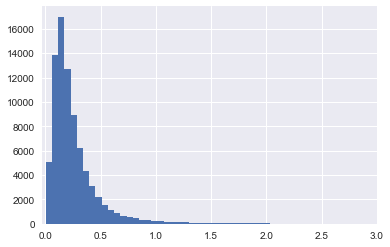

In [16]:
plt.hist(df2['reach_/_followers'], bins=1000)
plt.xlim(-.03,3)

(-0.003, 30)

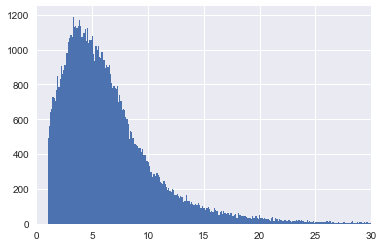

In [17]:
plt.hist(df2['reach_/_likes'], bins=1000)
plt.xlim(-.003, 30)

## Step 2 - Set confidence intervals for each ration

 *Just checking what some filters would look like without finding a confidence interval.* 

In [18]:
len(df2[(df2['reach_/_followers'] < df2['reach_/_followers'].quantile(.05))])

4069

In [19]:
len(df2[(df2['reach_/_followers'] > df2['reach_/_followers'].quantile(.95))])

4069

In [20]:
len(df2[(df2['reach_/_likes'] > df2['reach_/_likes'].quantile(.95))])

4069

In [21]:
len(df2[(df2['reach_/_likes'] < df2['reach_/_likes'].quantile(.05))])

4069

In [22]:
len(df2[(df2['reach_/_comments'] < df2['reach_/_comments'].quantile(.05))])

4069

In [23]:
len(df2[(df2['reach_/_comments'] > df2['reach_/_comments'].quantile(.95))])

4069

In [24]:
df2= df2.loc[(df2['reach_/_followers'] > df2['reach_/_followers'].quantile(.1))]
df2= df2.loc[(df2['reach_/_likes'] > df2['reach_/_likes'].quantile(.1))]
df2= df2.loc[(df2['reach_/_comments'] > df2['reach_/_comments'].quantile(.1))]

df2= df2.loc[(df2['reach_/_followers'] < df2['reach_/_followers'].quantile(.9))]
df2= df2.loc[(df2['reach_/_likes'] < df2['reach_/_likes'].quantile(.9))]
df2= df2.loc[(df2['reach_/_comments'] < df2['reach_/_comments'].quantile(.9))]

In [25]:
df2.head()

,followers,likes,comments,reach,reach_/_followers,reach_/_likes,reach_/_comments
727833,10305,391,29,1691,0.164095,4.324808,58.310345
439642,9394,733,38,1815,0.193208,2.476126,47.763158
674454,5252,114,16,1171,0.222963,10.271930,73.187500
207024,12463,366,38,1813,0.145471,4.953552,47.710526
473396,5285,290,16,1404,0.265658,4.841379,87.750000


In [26]:
len(df2)

43238

Now, what does our data look like? 

(array([710., 720., 722., 778., 748., 784., 717., 769., 786., 730., 733.,
        667., 674., 643., 653., 597., 651., 602., 606., 575., 567., 537.,
        549., 536., 523., 552., 506., 477., 476., 512., 431., 467., 442.,
        374., 421., 409., 404., 383., 372., 388., 371., 385., 338., 356.,
        318., 340., 324., 308., 288., 287., 304., 295., 286., 269., 251.,
        276., 278., 256., 259., 226., 264., 235., 259., 224., 247., 257.,
        232., 196., 215., 196., 200., 181., 206., 192., 194., 179., 180.,
        185., 181., 194., 191., 163., 196., 173., 172., 148., 168., 138.,
        149., 138., 159., 142., 145., 122., 133., 125., 139., 122., 119.,
        131., 114., 125., 135., 122., 115.,  96., 109., 127., 111., 123.,
        110., 110., 109., 102.,  95.,  99.,  87.,  85.,  99.,  97.,  94.,
         85.,  93.,  86.,  78.,  90.,  75.,  73., 101.,  64.,  92.,  78.,
         83.,  73.,  72.,  81.,  78.,  72.,  69.,  88.,  78.,  79.,  75.,
         65.,  73.,  66.,  63.,  76., 

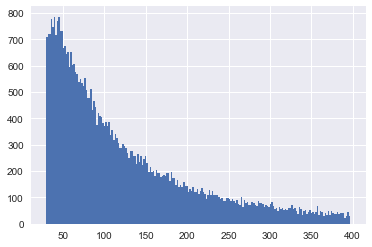

In [27]:
plt.hist(df2['reach_/_comments'], bins=200)

(array([182., 222., 226., 215., 230., 250., 235., 233., 250., 263., 294.,
        279., 281., 300., 287., 270., 309., 342., 307., 295., 355., 365.,
        329., 367., 331., 335., 354., 364., 372., 401., 358., 363., 335.,
        345., 331., 368., 344., 375., 373., 392., 365., 367., 369., 390.,
        333., 349., 347., 370., 362., 358., 379., 370., 363., 343., 329.,
        303., 362., 396., 326., 346., 361., 359., 372., 356., 342., 321.,
        334., 365., 352., 338., 310., 329., 329., 348., 318., 321., 339.,
        302., 310., 309., 321., 319., 319., 295., 291., 275., 255., 274.,
        240., 289., 258., 255., 277., 252., 286., 271., 263., 240., 241.,
        248., 233., 247., 243., 237., 221., 203., 225., 203., 206., 212.,
        212., 191., 222., 199., 191., 183., 189., 152., 156., 171., 166.,
        165., 174., 163., 147., 138., 162., 140., 141., 128., 148., 147.,
        136., 132., 149., 117., 148., 118., 124., 142., 134., 117., 119.,
        136., 112., 121., 109., 111., 

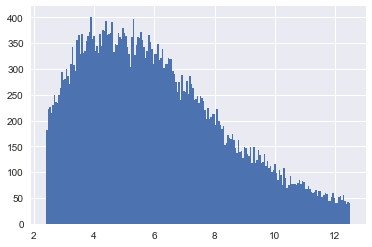

In [28]:
plt.hist(df2['reach_/_likes'], bins=200)

(array([348., 331., 338., 339., 369., 329., 358., 394., 406., 389., 388.,
        405., 391., 449., 435., 456., 452., 472., 481., 446., 482., 456.,
        489., 497., 478., 473., 492., 507., 464., 508., 469., 467., 454.,
        424., 469., 502., 479., 469., 445., 435., 447., 410., 441., 390.,
        377., 406., 393., 415., 379., 370., 339., 357., 382., 377., 351.,
        338., 376., 321., 343., 339., 284., 314., 317., 315., 282., 274.,
        280., 284., 269., 268., 295., 245., 264., 261., 257., 262., 238.,
        216., 213., 232., 238., 220., 221., 223., 220., 222., 195., 207.,
        202., 210., 192., 204., 193., 174., 205., 158., 165., 188., 164.,
        162., 176., 177., 152., 163., 157., 134., 146., 148., 154., 148.,
        148., 144., 152., 150., 123., 120., 120., 120., 134., 151., 110.,
        135., 104., 121., 113., 122., 136., 108., 106., 136.,  95.,  96.,
        100., 116., 117.,  97., 110.,  95., 100.,  85., 100.,  94.,  96.,
         88.,  85.,  88.,  78.,  81., 

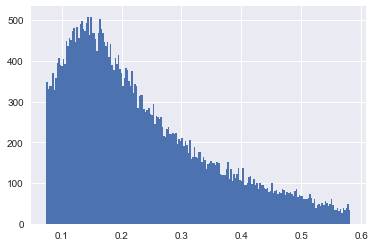

In [29]:
plt.hist(df2['reach_/_followers'], bins=200)


# Fit the model

In [30]:
lr_model = ols(formula='reach~followers + likes + comments', data=df2).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                 1.991e+04
Date:                Fri, 08 Mar 2019   Prob (F-statistic):               0.00
Time:                        10:55:36   Log-Likelihood:            -3.4681e+05
No. Observations:               43238   AIC:                         6.936e+05
Df Residuals:                   43234   BIC:                         6.937e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -48.9234     14.475     -3.380      0.001     -77.294     -20.553
followers      0.0979      0.002     58.457      0.000       0.095       0.101
likes          2.7471      0.018    151.387      0.000       2.712       2.783
comments       7.8284      0.221     35.436      0.000       7.395       8.261
==============================================================================
Omnibus:                     6651.661   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12363.852
Skew:                           0.977   Prob(JB):                         0.00
Kurtosis:                       4.744   Cond. No.                     3.67e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Scatterplots 
- Next we look at scatter plots of our data to further look for outliers and the correlation of our independent variable to our dependent variable. 

Text(0.5, 1.0, 'Followers Scatter plot')

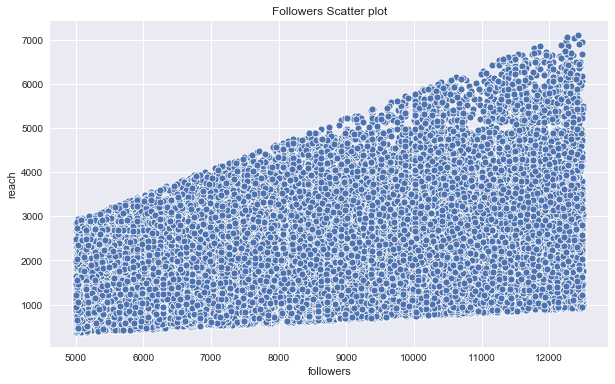

In [31]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df2.followers, y=df2.reach)
plt.xlabel('followers')
plt.ylabel('reach')
plt.title("Followers Scatter plot")

Text(0.5, 1.0, 'Likes Scatter plot')

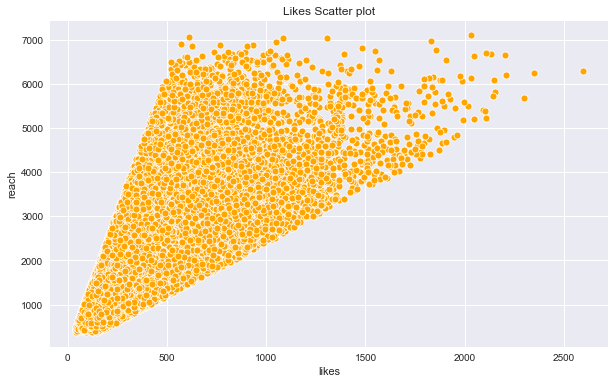

In [32]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df2.reach, x=df2.likes, color='orange' )
plt.xlabel('likes')
plt.ylabel('reach')
plt.title("Likes Scatter plot")

Text(0.5, 1.0, 'Comments Scatter plot')

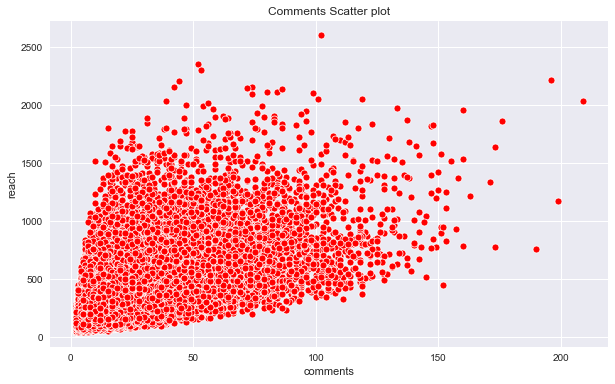

In [33]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df2.likes, x=df2.comments, color='red')
plt.xlabel('comments')
plt.ylabel('reach')
plt.title("Comments Scatter plot")

Further we used Statsmodels to create an OLS model. This allows us to see all the import statistics and values associated with the three variables together. 

In [34]:
lr_model = ols(formula='reach~followers+likes+comments', data=df2).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                 1.991e+04
Date:                Fri, 08 Mar 2019   Prob (F-statistic):               0.00
Time:                        10:55:39   Log-Likelihood:            -3.4681e+05
No. Observations:               43238   AIC:                         6.936e+05
Df Residuals:                   43234   BIC:                         6.937e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -48.9234     14.475     -3.380      0.001     -77.294     -20.553
followers      0.0979      0.002     58.457      0.000       0.095       0.101
likes          2.7471      0.018    151.387      0.000       2.712       2.783
comments       7.8284      0.221     35.436      0.000       7.395       8.261
==============================================================================
Omnibus:                     6651.661   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12363.852
Skew:                           0.977   Prob(JB):                         0.00
Kurtosis:                       4.744   Cond. No.                     3.67e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Test the Model

Create a quick function to run the coefficients from the three variables. 

### Add Test Reach to the original data Frame to check for accuracy

In [35]:
test['test_reach'] = round(lr_model.predict(test),1)

In [36]:
test['reach_diff'] = round(test['reach'] - test['test_reach'],1)

In [37]:
test.head()

,followers,likes,comments,reach,test_reach,reach_diff
699989,7216,124,2,1487,1014.1,472.9
65595,9862,118,2,738,1256.7,-518.7
565690,10067,384,59,2121,2453.7,-332.7
166650,5237,129,53,290,1233.2,-943.2
308710,10183,307,20,1180,1948.3,-768.3


In [38]:
test['diff_ratio'] = round((test.reach_diff / test.reach)*100, 1)

(-300, 300)

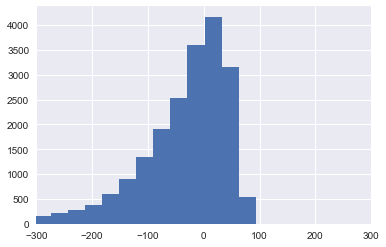

In [39]:
x = plt.hist(test.diff_ratio, bins = 100)
plt.xlim(-300, 300)

In [40]:
mean_squared_error(test.reach, test.test_reach)**.5, lr_model.rsquared

(2992.0435929985047, 0.5801278032984949)

In [41]:
df2.describe()

,followers,likes,comments,reach,reach_/_followers,reach_/_likes,reach_/_comments
count,43238.000000,43238.000000,43238.000000,43238.000000,43238.000000,43238.000000,43238.000000
mean,8707.293885,369.358504,23.724293,2004.191614,0.232609,6.089067,123.524482
std,2214.632170,246.451537,19.685760,1136.816478,0.118817,2.355696,85.803875
min,5001.000000,40.000000,2.000000,377.000000,0.073888,2.407266,29.342105
25%,6711.000000,197.000000,10.000000,1164.000000,0.139687,4.209141,56.866391
50%,8763.500000,303.000000,18.000000,1721.000000,0.202092,5.735416,95.466667
75%,10559.000000,471.000000,31.000000,2559.000000,0.301505,7.602454,166.549020
max,12499.000000,2596.000000,209.000000,7104.000000,0.582022,12.511765,397.250000


## Interactions.
Lets create to see how our three variables are interacting with each other in the model. 

In [42]:
from sklearn.linear_model import LinearRegression
regression_1 = LinearRegression()
regression_2 = LinearRegression()
regression_3 = LinearRegression()

likes = df2["likes"].values.reshape(-1, 1)
comments = df2["comments"].values.reshape(-1, 1)
followers = df2["followers"].values.reshape(-1, 1)

regression_1.fit(likes, df2["reach"])
regression_2.fit(comments, df2["reach"])
regression_3.fit(followers, df2["reach"])

# Make predictions using the testing set
pred_1 = regression_1.predict(likes)
pred_2 = regression_2.predict(comments)
pred_3 = regression_3.predict(followers)

# The coefficients
print(regression_1.coef_)
print(regression_2.coef_)
print(regression_3.coef_)

[3.37039711]
[29.8399319]
[0.20160867]


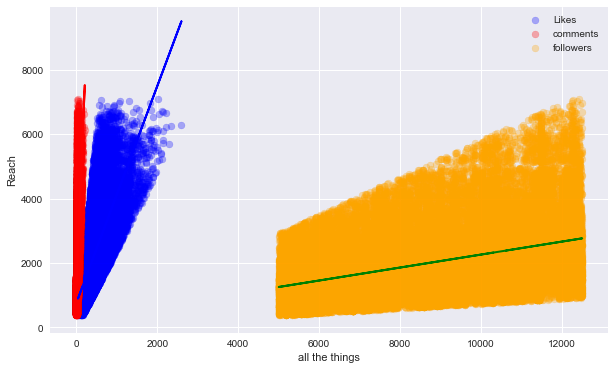

In [43]:
# Plot outputs
plt.figure(figsize=(10,6))

plt.scatter(likes, df2["reach"],  color='blue', alpha = 0.3, label = "Likes")
plt.scatter(comments, df2["reach"],  color='red', alpha = 0.3, label = "comments")
plt.scatter(followers, df2["reach"],  color='orange', alpha = 0.3, label = "followers")

plt.plot(likes, pred_1,  color='blue', linewidth=2)
plt.plot(comments, pred_2,  color='red', linewidth=2)
plt.plot(followers, pred_3,  color='green', linewidth=2)
plt.ylabel("Reach")
plt.xlabel("all the things")
plt.legend();

## Summary of Users with 5k to 12.5k followers

We ran an analysis with our test data and got a RMSE of 3276k and an $R^2$ of 0.582. This is a departure from our 1k-5k bin analysis. Our $R^2$ went from 73% down to 58% and our RMSE went from 1335 up to 3276. Our analysis for this bin and our model has become less predictive.